In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

In [2]:
df = pd.read_csv("sentiment_analysis.csv")
df.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [3]:
df.drop(["Day", 'Year', 'Month', 'Time of Tweet', 'Platform'], inplace=True, axis=1)

In [4]:
df.head()

,text,sentiment
0,What a great day!!! Looks like dream.,positive
1,"I feel sorry, I miss you here in the sea beach",positive
2,Don't angry me,negative
3,We attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",negative


In [5]:
df["sentiment"].unique()

array(['positive', 'negative', 'neutral'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
lb = LabelEncoder()
df["label_sentiment"] = lb.fit_transform(df["sentiment"])

In [8]:
df.head()

,text,sentiment,label_sentiment
0,What a great day!!! Looks like dream.,positive,2
1,"I feel sorry, I miss you here in the sea beach",positive,2
2,Don't angry me,negative,0
3,We attend in the class just for listening teac...,negative,0
4,"Those who want to go, let them go",negative,0


In [9]:
df.isnull().sum()

text               0
sentiment          0
label_sentiment    0
dtype: int64

In [10]:
df["sentiment"].value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [11]:
import matplotlib.pyplot as plt

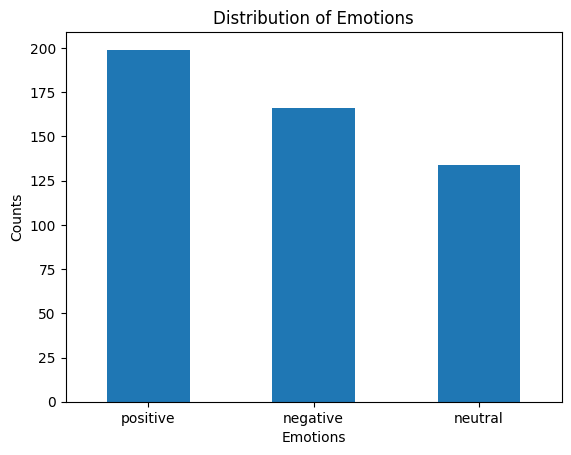

In [12]:
value_counts = df["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['positive', 'negative', 'neutral'], rotation=0)

plt.title('Distribution of Emotions')
plt.xlabel('Emotions')
plt.ylabel('Counts')

plt.show()

In [13]:
df

,text,sentiment,label_sentiment
0,What a great day!!! Looks like dream.,positive,2
1,"I feel sorry, I miss you here in the sea beach",positive,2
2,Don't angry me,negative,0
3,We attend in the class just for listening teac...,negative,0
4,"Those who want to go, let them go",negative,0
...,...,...,...
494,"According to , a quarter of families under six...",negative,0
495,the plan to not spend money is not going well,negative,0
496,uploading all my bamboozle pictures of facebook,neutral,1
497,congratulations ! you guys finish a month ear...,positive,2


In [14]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label_sentiment'], train_size=0.75, shuffle = True)

In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [16]:
train_tokens = tokenizer(list(x_train), padding = True, truncation=True)
test_tokens = tokenizer(list(x_test), padding = True, truncation=True)

In [17]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [18]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[101, 1422, 13319, 1663, 1110, 1919, 141, 14962, 16523, 2069, 9537, 1822, 1113, 12816, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] My Sharpie is running DANGERously low on ink [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [19]:
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = x_train
            self.tokens = train_tokens
            self.labels = list(y_train)
        else:
            self.text_data = x_test
            self.tokens = test_tokens
            self.labels = list(y_test)

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample

In [20]:
batch_size = 16
train_dataset = TokenData(train = True)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

test_dataset = TokenData(train = False)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

In [21]:
num_classes = 9
bert_model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=num_classes) 
optimizer = AdamW(bert_model.parameters(), lr=1e-5) 
loss_fn = torch.nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
torch.cuda.empty_cache()

In [23]:
num_epochs = 3
device = "cpu"
bert_model.to(device) # Transfer model to GPU if available

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [24]:
torch.cuda.empty_cache()

In [25]:
for epoch in range(num_epochs):
    print("Epoch: ", (epoch + 1))
    bert_model.train()
    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Check for out-of-bound labels
        if (batch['labels'] >= num_classes).any():
            print(f"Out-of-bound label found in batch {i+1}: ", batch['labels'])
            continue  # Skip this batch

        optimizer.zero_grad()
        outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        pred = outputs.logits
        loss = loss_fn(pred, batch['labels'])
        loss.backward()
        optimizer.step()
        train_batch_loss = loss.item()
        train_last_loss = train_batch_loss / batch['input_ids'].size(0)

        print('Training batch {} last loss: {}'.format(i + 1, train_last_loss))
    print(f"\nTraining epoch {epoch + 1} loss: ", train_last_loss)

    bert_model.eval()
    correct = 0
    for i, batch in enumerate(test_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        logits = outputs.logits
        loss = loss_fn(logits, batch['labels'])
        test_batch_loss = loss.item()
        test_last_loss = test_batch_loss / batch['input_ids'].size(0)
        print('Testing batch {} loss: {}'.format(i + 1, test_last_loss))

        correct += (logits.argmax(1) == batch['labels']).sum().item()
        print("Testing accuracy: ", correct / ((i + 1) * batch['input_ids'].size(0)))

    print(f"\nTesting epoch {epoch + 1} last loss: ", test_last_loss)

Epoch:  1
Training batch 1 last loss: 0.14106597006320953
Training batch 2 last loss: 0.14314334094524384
Training batch 3 last loss: 0.126614511013031
Training batch 4 last loss: 0.15440648794174194
Training batch 5 last loss: 0.1243174821138382
Training batch 6 last loss: 0.1327928751707077
Training batch 7 last loss: 0.12581568956375122
Training batch 8 last loss: 0.1333906501531601
Training batch 9 last loss: 0.11242814362049103
Training batch 10 last loss: 0.12320354580879211
Training batch 11 last loss: 0.11810328811407089
Training batch 12 last loss: 0.12420401722192764
Training batch 13 last loss: 0.13248705863952637
Training batch 14 last loss: 0.1158706322312355
Training batch 15 last loss: 0.11173948645591736
Training batch 16 last loss: 0.100409597158432
Training batch 17 last loss: 0.10503875464200974
Training batch 18 last loss: 0.10826652497053146
Training batch 19 last loss: 0.10708161443471909
Training batch 20 last loss: 0.10859351605176926
Training batch 21 last loss